In [1]:
import IPython
import numpy as np
import pickle as pkl
import tvm
import tvm.testing
from tvm.ir.module import IRModule
from tvm.script import tir as T, relax as R
from tvm import relax, topi, te
from __future__ import annotations

In [2]:
def code2html(code):
	"""Helper function to use pygments to turn the code string into highlighted html."""
	import pygments
	from pygments.lexers import Python3Lexer
	from pygments.formatters import HtmlFormatter
	formatter = HtmlFormatter(style="github-dark")
	html = pygments.highlight(code, Python3Lexer(), formatter)
	return "<style>%s</style>%s\n" % (formatter.get_style_defs(".highlight"), html)

In [3]:
# Hide outputs
!wget -nc https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_assignment_params.pkl

# Load the weight map from file.
# The prediction accuracy of the weight map on test data is around 83.3%.
weight_map = pkl.load(open("fasionmnist_mlp_assignment_params.pkl", "rb"))
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

File ‘fasionmnist_mlp_assignment_params.pkl’ already there; not retrieving.



In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data.dataloader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

batch_size = 4
input_shape = (batch_size, 1, 28, 28)  # NCHW layout


def pytorch_model():
    list = []
    list.append(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), bias=True))
    list.append(nn.ReLU())
    list.append(nn.MaxPool2d(kernel_size=(2, 2)))
    list.append(nn.Flatten())
    list.append(nn.Linear(in_features=5408, out_features=100, bias=True))
    list.append(nn.ReLU())
    list.append(nn.Linear(in_features=100, out_features=10, bias=True))
    list.append(nn.Softmax(dim=1))

    model = nn.Sequential(*list).cpu()
    name_map = {
        "0.weight": "conv2d_weight",
        "0.bias": "conv2d_bias",
        "4.weight": "linear0_weight",
        "4.bias": "linear0_bias",
        "6.weight": "linear1_weight",
        "6.bias": "linear1_bias",
    }
    for name, param in model.named_parameters():
        param.data = torch.from_numpy(weight_map[name_map[name]]).cpu()
    return model

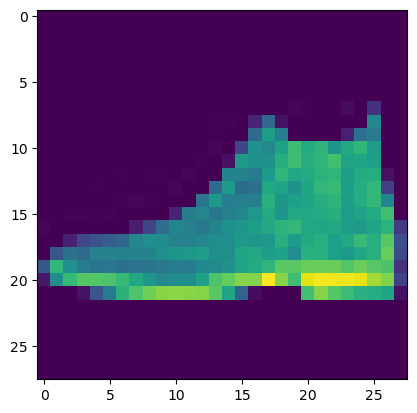

predict: Ankle boot, label: Ankle boot

Test set: Average loss: -0.8369, Accuracy: 8388/10000 (84%)



In [5]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        print_img = True
        for data, label in test_loader:
            data, label = data.cpu(), label.cpu()
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, label, reduction="sum").item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            if print_img:
                imshow(data[0])
                print("predict: {}, label: {}".format(class_names[pred[0][0]], class_names[label[0]]))
                print_img = False
            correct += pred.eq(label.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


test_data = torchvision.datasets.FashionMNIST(
    "./data",
    download=True,
    train=False,
    transform=transforms.Compose([transforms.ToTensor()])
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=False)
test(pytorch_model(), test_loader)

In [6]:
def relu(A):
    B = te.compute(shape=(128, 128), fcompute=lambda i, j: te.max(A[i, j], 0), name="B")
    return B


def emit_te_example():
    bb = relax.BlockBuilder()
    x = relax.Var("x", relax.TensorStructInfo(shape=(128, 128), dtype="float32"))
    with bb.function("main", [x]):
        with bb.dataflow():
            lv0 = bb.emit_te(relu, x)
            gv = bb.emit_output(lv0)
        bb.emit_func_output(gv)
    return bb.get()

In [7]:
mod = emit_te_example()
IPython.display.HTML(code2html(mod.script()))

In [8]:
print(pytorch_model()[0])

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))


In [ ]:
def create_model_via_emit_te():
    bb = relax.BlockBuilder()
    x = relax.Var("x", relax.TensorStructInfo(shape=input_shape, dtype="float32"))

    conv2d_weight = relax.const(weight_map["conv2d_weight"], "float32")
    conv2d_bias = relax.const(weight_map["conv2d_bias"].reshape(1, 32, 1, 1), "float32")
    linear0_weight = relax.const(weight_map["linear0_weight"].T, "float32")
    linear0_bias = relax.const(weight_map["linear0_bias"].reshape(-1), "float32")
    linear1_weight = relax.const(weight_map["linear1_weight"].T, "float32")
    linear1_bias = relax.const(weight_map["linear1_bias"].reshape(-1), "float32")

    with bb.function("main", [x]):
        with bb.dataflow():
            lv0 = bb.emit_te(topi.nn.conv2d_nchw, x, conv2d_weight, 1, 0, 1, "float32")
            lv1 = bb.emit_te(topi.nn.add, lv0, conv2d_bias)
            lv2 = bb.emit_te(topi.nn.relu, lv1)
            lv3 = bb.emit_te(topi.nn.pool2d, lv2, (2, 2), (2, 2), (1, 1), (0, 0, 0, 0), 'max')
            lv4 = bb.emit_te(topi.nn.flatten, lv3)
            lv5 = bb.emit_te(topi.nn.matmul, lv4, linear0_weight, linear0_bias)
            lv6 = bb.emit_te(topi.nn.relu, lv5)
            lv7 = bb.emit_te(topi.nn.matmul, lv6, linear1_weight, linear1_bias)
            lv8 = bb.emit_te(topi.nn.softmax, lv7, 1)
        bb.emit_func_output(lv8)
    return bb.get()


def build_mod(mod):
    exec = relax.build(mod, "llvm")
    dev = tvm.cpu()
    vm = relax.VirtualMachine(exec, dev)
    return vm


def check_equivalence(mod, torch_model, test_loader):
    torch_model.eval()
    with torch.no_grad():
        rt_mod = build_mod(mod)
        for data, label in test_loader:
            data, label = data.cpu(), label.cpu()
            output_from_pytorch = torch_model(data).numpy()
            output_from_relax = rt_mod["main"](tvm.nd.array(data, tvm.cpu())).numpy()
            tvm.testing.assert_allclose(output_from_pytorch, output_from_relax, rtol=1e-4)


test_data = torchvision.datasets.FashionMNIST(
    "./data",
    download=True,
    train=False,
    transform=transforms.Compose([transforms.ToTensor()])
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

mod = create_model_via_emit_te()
torch_model = pytorch_model()

check_equivalence(mod, torch_model, test_loader)
IPython.display.HTML(code2html(mod.script()))

In [111]:
@tvm.register_func("env.linear", override=True)
def torch_linear(x: tvm.nd.NDArray,
                 w: tvm.nd.NDArray,
                 b: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    torch.mm(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)

@tvm.register_func("env.conv", override=True)
def torch_conv2d(x: tvm.nd.NDArray,
                 w: tvm.nd.NDArray,
                 b: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    # out_torch = torch.conv2d(x_torch, w_torch)
    layer = torch.nn.functional.conv2d(x_torch, w_torch, b_torch)
    torch.add(layer, 0., out=out_torch)

@tvm.register_func("env.relu", override=True)
def torch_relu(x: tvm.nd.NDArray,
               out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    layer = torch.nn.functional.relu(x_torch)
    torch.add(layer, 0., out=out_torch)

@tvm.register_func("env.maxpool", override=True)
def torch_maxpool2d(x: tvm.nd.NDArray,
                    out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    layer = torch.nn.functional.max_pool2d(x_torch, kernel_size=(2, 2), stride=2, padding=0)
    torch.add(layer, 0., out=out_torch)
    # out_torch = torch.max_pool2d(input=x_torch, kernel_size=(2, 2), stride=2, padding=0)

@tvm.register_func("env.flatten", override=True)
def torch_flatten(x: tvm.nd.NDArray,
                  out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    layer = torch.nn.Flatten(start_dim=1, end_dim=-1)
    torch.add(layer(x_torch), 0., out=out_torch)
    # out_torch = torch.flatten(input=x_torch, start_dim=1, end_dim=-1)

@tvm.register_func("env.softmax", override=True)
def torch_softmax(x: tvm.nd.NDArray,
                  out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    torch.softmax(input=x_torch, dim=1, dtype=torch.float32, out=out_torch)

In [117]:
def create_model_with_torch_func():
    bb = relax.BlockBuilder()

    x = relax.Var("x", relax.TensorStructInfo(shape=input_shape, dtype="float32"))

    conv2d_weight = relax.const(weight_map["conv2d_weight"], "float32")
    conv2d_bias = relax.const(weight_map["conv2d_bias"], "float32")
    linear0_weight = relax.const(weight_map["linear0_weight"], "float32")
    linear0_bias = relax.const(weight_map["linear0_bias"].reshape(1, 100), "float32")
    linear1_weight = relax.const(weight_map["linear1_weight"], "float32")
    linear1_bias = relax.const(weight_map["linear1_bias"].reshape(1, 10), "float32")

    with bb.function("main", [x]):
        with bb.dataflow():
            lv0 = R.call_dps_packed("env.conv", (x, conv2d_weight, conv2d_bias), relax.TensorStructInfo((batch_size, 32, 26, 26), dtype="float32"))
            lv1 = R.call_dps_packed("env.relu", lv0, relax.TensorStructInfo((batch_size, 32, 26, 26), dtype="float32"))
            lv2 = R.call_dps_packed("env.maxpool", lv1, relax.TensorStructInfo((batch_size, 32, 13, 13), dtype="float32"))
            lv3 = R.call_dps_packed("env.flatten", lv2, relax.TensorStructInfo((batch_size, 5408), dtype="float32"))
            lv4 = R.call_dps_packed("env.linear", (lv3, linear0_weight, linear0_bias), relax.TensorStructInfo((batch_size, 100), dtype="float32"))
            lv5 = R.call_dps_packed("env.relu", lv4, relax.TensorStructInfo((batch_size, 100), dtype="float32"))
            lv6 = R.call_dps_packed("env.linear", (lv5, linear1_weight, linear1_bias), relax.TensorStructInfo((batch_size, 10), dtype="float32"))
            lv7 = R.call_dps_packed("env.softmax", lv6, relax.TensorStructInfo((batch_size, 10), dtype="float32"))
        bb.emit_func_output(lv7)

    return bb.get()


test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
mod = create_model_with_torch_func()
check_equivalence(mod, torch_model, test_loader)